<a href="https://colab.research.google.com/github/silencio94/deep_learning_with_numpy/blob/master/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear regression
___
Implemented in numpy.

## Requirements
___

In [0]:
import numpy as np
import matplotlib.pyplot as plt

## Generator
___
Generator gernerate $(x_i, y_i)$ samples based on single weight and bias,</br>
where: </br>
<center>
$\mathbf{w} \sim \mathcal{U}[-R,R]^d$</br>
$b \sim \mathcal{U}[-R,R]$</br>
</br>
$\mathbf{x}_{i} \sim \mathcal{U}[-R,R]^d$</br>
$y_{i} \sim \mathcal{N}(\mathbf{w}^{T}\mathbf{x}_{i}+b, \sigma^2)\;(\sigma=\alpha R)$</br>
</center></br>
In other words, sample is generated by shallow neural network.


In [0]:
def gen_dataset(N=1000, R=10, d=5, alpha=0.1, history=False):
    w = np.random.uniform(-R, R, d)
    b = np.random.uniform(-R, R)
    
    print '[ Generator Info ]'
    print 'w: %s' % w
    print 'b: %s' % b

    training_set = []
    dev_set = []
    test_set = []
    for i in xrange(N):
        x = np.random.uniform(-R, R, d)
        y = np.random.normal(np.dot(w, x) + b, alpha*R)

        if history:
            print 'Data_%d' % i
            print 'x : %s' % x
            print 'y : %s' % y

        if i < N*0.85:
            training_set.append((x, y))
        elif i < N*0.90:
            dev_set.append((x, y))
        else:
            test_set.append((x, y))

    #with open('random_dataset_%d.pkl' % N, 'wb') as f:
        #cPickle.dump({'train': training_set, 'dev': dev_set, 'test': test_set}, f, cPickle.HIGHEST_PROTOCOL)
    return {'train': training_set, 'dev': dev_set, 'test': test_set}

## Model architecture
___



$pval(\mathbf{x}_i)\;(=\hat{y}_i)$ is a predicted value of $\mathbf{x}_i$.</br>
$val(\mathbf{x}_i)\;(=y_i)$ is a actual value of $\mathbf{x}_i$.

In [0]:
def pval(e, w, b):
    return np.dot(w, e[0]) + b


def val(e):
    return e[1]

Model architecture is simple shallow neural network. Generator is shallow neural network and also our model is  shallow neural network (both with single layer). This ideal circumstance will lead our model to best model performance. 

![figure1](https://miro.medium.com/max/391/1*CfdaqnNb6RHLzPJTt1UXjQ.png)

### Early stopping
Early stopping is technique for detecting overfitting.</br>
more details in here : https://en.wikipedia.org/wiki/Early_stopping




[ Generator Info ]
w: [-5.73026448  4.6971426   2.94016959  0.84288504 -3.91081498 -6.77202389
  0.8222786   6.82771333  9.10309174 -8.68865194]
b: -7.60505505441
[1/100]  train_MSE: 7642722.45  dev_MSE: 565033.05  test_MSE: 1057290.10
[2/100]  train_MSE: 6566790.29  dev_MSE: 486605.79  test_MSE: 911150.74
[3/100]  train_MSE: 5591099.37  dev_MSE: 413015.61  test_MSE: 775721.15
[4/100]  train_MSE: 4497290.52  dev_MSE: 330603.69  test_MSE: 624642.21
[5/100]  train_MSE: 3829194.30  dev_MSE: 281975.80  test_MSE: 541336.30
[6/100]  train_MSE: 3264848.35  dev_MSE: 240093.77  test_MSE: 460927.09
[7/100]  train_MSE: 2766476.44  dev_MSE: 201842.61  test_MSE: 390319.71
[8/100]  train_MSE: 2435077.03  dev_MSE: 177564.64  test_MSE: 340769.77
[9/100]  train_MSE: 2070635.20  dev_MSE: 152245.89  test_MSE: 289760.44
[10/100]  train_MSE: 1737063.90  dev_MSE: 127528.80  test_MSE: 242841.79
[11/100]  train_MSE: 1430392.44  dev_MSE: 104611.27  test_MSE: 201012.66
[12/100]  train_MSE: 1167961.19  dev_MSE: 

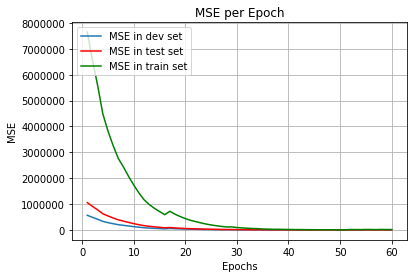


w: [-5.41929504  4.36234027  3.22785909  0.9136149  -4.11921704 -7.09167125
  0.9027557   6.81438722  9.44424476 -8.86824095]
b: -7.527861175653922
MSE in test set: 549.799788313056


In [27]:
def linear_regression(D, epochs=100, learning_rate=0.1, minibatch=10, history=False, patience=10):
    D_train = D['train']
    D_dev = D['dev']
    D_test = D['test']

    # initialize model parameters
    w = np.zeros(len(D_train[0][0]))
    b = 0

    x, y, y2, y3 = [], [], [], []
    linear_models = []

    # for early_stopping
    best_devmse = (0, float('inf'))
    patience_cnt = patience
    early_stopping = False

    for epoch in xrange(epochs):

        w, b = SGD(D_train, w, b, learning_rate, minibatch, history)

        devmse = sum((pval(D_dev[e_idx], w, b) - val(D_dev[e_idx]))**2 for e_idx in xrange(len(D_dev)))
        testmse = sum((pval(D_test[e_idx], w, b) - val(D_test[e_idx]))**2 for e_idx in xrange(len(D_test)))
        trainmse = sum((pval(D_train[e_idx], w, b) - val(D_train[e_idx]))**2 for e_idx in xrange(len(D_train)))

        print '[{}/{}]  train_MSE: {:.2f}  dev_MSE: {:.2f}  test_MSE: {:.2f}'.format(epoch+1, epochs, trainmse, devmse, testmse)

        x.append(epoch + 1)
        y.append(devmse)
        y2.append(testmse)
        y3.append(trainmse)

        # simple early stopping
        if best_devmse[1] > devmse:
            best_devmse = (epoch, devmse)
            patience_cnt = patience
        else:
            patience_cnt -= 1
            if not patience_cnt:
                early_stopping = True
                print 'Early stopping: Overfitting at %dth epoch' % (best_devmse[0]+1)
                break

        # Add available models
        linear_models.append((w, b, testmse))

    plt.title('MSE per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.plot(x, y, label='MSE in dev set')
    plt.plot(x, y2, 'r', label='MSE in test set')
    plt.plot(x, y3, 'g', label='MSE in train set')
    plt.legend(loc=2)
    plt.grid(True)
    plt.show()

    if early_stopping:
        return min(linear_models[:best_devmse[0]], key=lambda m: m[2])
    else:
        return min(linear_models, key=lambda m: m[2])


def SGD(train, w, b, learning_rate=0.1, minibatch=10, history=False):
    np.random.shuffle(train)
    trainsize = len(train)

    for i in xrange(0, trainsize, minibatch):
        if i + minibatch > trainsize:
            minibatch = trainsize - i

        X = np.column_stack([train[j][0] for j in xrange(i, i+minibatch)])
        y = np.array([train[j][1]-b for j in xrange(i, i+minibatch)])

        local_w = np.linalg.lstsq(np.dot(X, X.T), np.dot(X, y), rcond=None)[0]
        local_b = np.mean(y) + b - np.mean(np.dot(w, X))

        # ISGD update
        w -= (w - local_w) * learning_rate
        b -= (b - local_b) * learning_rate
        MSE = sum((pval(train[e_idx], w, b) - val(train[e_idx]))**2 for e_idx in xrange(i + minibatch))

        if history:
            print '-----------------------------'
            print 'Train progress: %.2f %%' % (((i+1.0)/trainsize)*100)
            print "w: %s" % w
            print "b: %s" % b
            print "MSE in train set: %s" % MSE

    return w, b


D = gen_dataset(1000, d=10)

# [0] weight vector [1] bias [2] test mse
model = linear_regression(D, learning_rate=0.001, history=False)

print '\nw: %s' % model[0]
print 'b: %s' % model[1]
print 'MSE in test set: %s' % model[2]


Try another dataset.
https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset

[1/300]  train_MSE: 89023.17  dev_MSE: 18007.48  test_MSE: 8992.38
[2/300]  train_MSE: 87336.71  dev_MSE: 17793.57  test_MSE: 8589.46
[3/300]  train_MSE: 85682.96  dev_MSE: 17583.21  test_MSE: 8199.91
[4/300]  train_MSE: 84061.28  dev_MSE: 17376.34  test_MSE: 7823.40
[5/300]  train_MSE: 82471.04  dev_MSE: 17172.89  test_MSE: 7459.60
[6/300]  train_MSE: 80911.62  dev_MSE: 16972.80  test_MSE: 7108.18
[7/300]  train_MSE: 79382.42  dev_MSE: 16776.01  test_MSE: 6768.85
[8/300]  train_MSE: 77882.85  dev_MSE: 16582.46  test_MSE: 6441.30
[9/300]  train_MSE: 76412.31  dev_MSE: 16392.10  test_MSE: 6125.22
[10/300]  train_MSE: 74970.25  dev_MSE: 16204.86  test_MSE: 5820.34
[11/300]  train_MSE: 73556.10  dev_MSE: 16020.70  test_MSE: 5526.36
[12/300]  train_MSE: 72169.31  dev_MSE: 15839.55  test_MSE: 5243.01
[13/300]  train_MSE: 70809.36  dev_MSE: 15661.36  test_MSE: 4970.02
[14/300]  train_MSE: 69475.71  dev_MSE: 15486.08  test_MSE: 4707.12
[15/300]  train_MSE: 68167.84  dev_MSE: 15313.66  test_MS

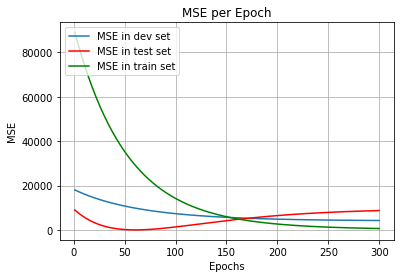


w: [ -397.03161672  -179.01497498   361.78147181  -792.273817
  -579.71429113  -207.80910299  -907.78484937   406.15806346
   213.55426276 -1012.5460527 ]
b: 32.43490548876174
MSE in test set: 0.19


In [28]:
from sklearn import datasets

diabetes = datasets.load_diabetes()
dsize = len(diabetes)

D = {
    'train':
        [(diabetes['data'][i], diabetes['target'][i]) for i in xrange(int(dsize*0.8))],
    'dev':
        [(diabetes['data'][i], diabetes['target'][i]) for i in xrange(int(dsize*0.8), int(dsize*0.85))],
    'test':
        [(diabetes['data'][i], diabetes['target'][i]) for i in xrange(int(dsize * 0.85), dsize)]
    }

# [0] weight vector [1] bias [2] test mse
model = linear_regression(D, epochs=300, learning_rate=0.005, history=False)

print '\nw: %s' % model[0]
print 'b: %s' % model[1]
print 'MSE in test set: %.2f' % model[2]